<img src="https://cdn.siberian.dev/siberian.png" alt="Siberian Logo">

# Least Angle Regression with MinMaxScaler and Quantile Transformer

This Code template is for the regression analysis using LARS Regressor and the feature transformation technique Quantile Transformer and MinMax Scaling rescaling technique in a pipeline.

### **Required Packages**

In [ ]:
import warnings
import numpy as np 
import pandas as pd 
import seaborn as se 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import QuantileTransformer,MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
from sklearn.linear_model import Lars
warnings.filterwarnings('ignore')

### **Initialization**
Filepath of CSV file

In [ ]:
file_path= ""

List of features which are required for model training .

In [ ]:
features = []

Target feature for prediction.

In [ ]:
target = ''

### **Dataset Overview**
Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [ ]:
df=pd.read_csv(file_path)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### **Dataset Information**
Print a concise summary of a DataFrame.

We will use info() method to print the information about the DataFrame including the index dtype and columns, non-null values and memory usage.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### **Dataset Describe**
Generate descriptive statistics.

Descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

We will analyzes both numeric and object series, as well as DataFrame column sets of mixed data types. 

In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### **Feature Selection**
It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X and target/outcome to Y.

In [ ]:
X=df[features]
Y=df[target]

### **Data Preprocessing**
Since we do not know what is the number of Null values in each column.So,we print the columns arranged in descreasnig orde 

In [ ]:
print(df.isnull().sum().sort_values(ascending=False))

charges     0
region      0
smoker      0
children    0
bmi         0
sex         0
age         0
dtype: int64


Since the majority of the machine learning models in the Sklearn library doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippet have functions, which removes the null value if any exists. And convert the string classes data in the datasets by encoding them to integer classes.

In [ ]:
def NullClearner(df):
    if(isinstance(df, pd.Series) and (df.dtype in ["float64","int64"])):
        df.fillna(df.mean(),inplace=True)
        return df
    elif(isinstance(df, pd.Series)):
        df.fillna(df.mode()[0],inplace=True)
        return df
    else:return df
def EncodeX(df):
    return pd.get_dummies(df)

Calling preprocessing functions on the feature and target set.

In [ ]:
x=X.columns.to_list()
for i in x:
    X[i]=NullClearner(X[i])
X=EncodeX(X)
Y=NullClearner(Y)
X.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1,0,0,1,0,0,0,1
1,18,33.770,1,0,1,1,0,0,0,1,0
2,28,33.000,3,0,1,1,0,0,0,1,0
3,33,22.705,0,0,1,1,0,0,1,0,0
4,32,28.880,0,0,1,1,0,0,1,0,0


#### **Correlation Map**
In order to check the correlation between the features, we will plot a correlation matrix. It is effective in summarizing a large amount of data where the goal is to see patterns.

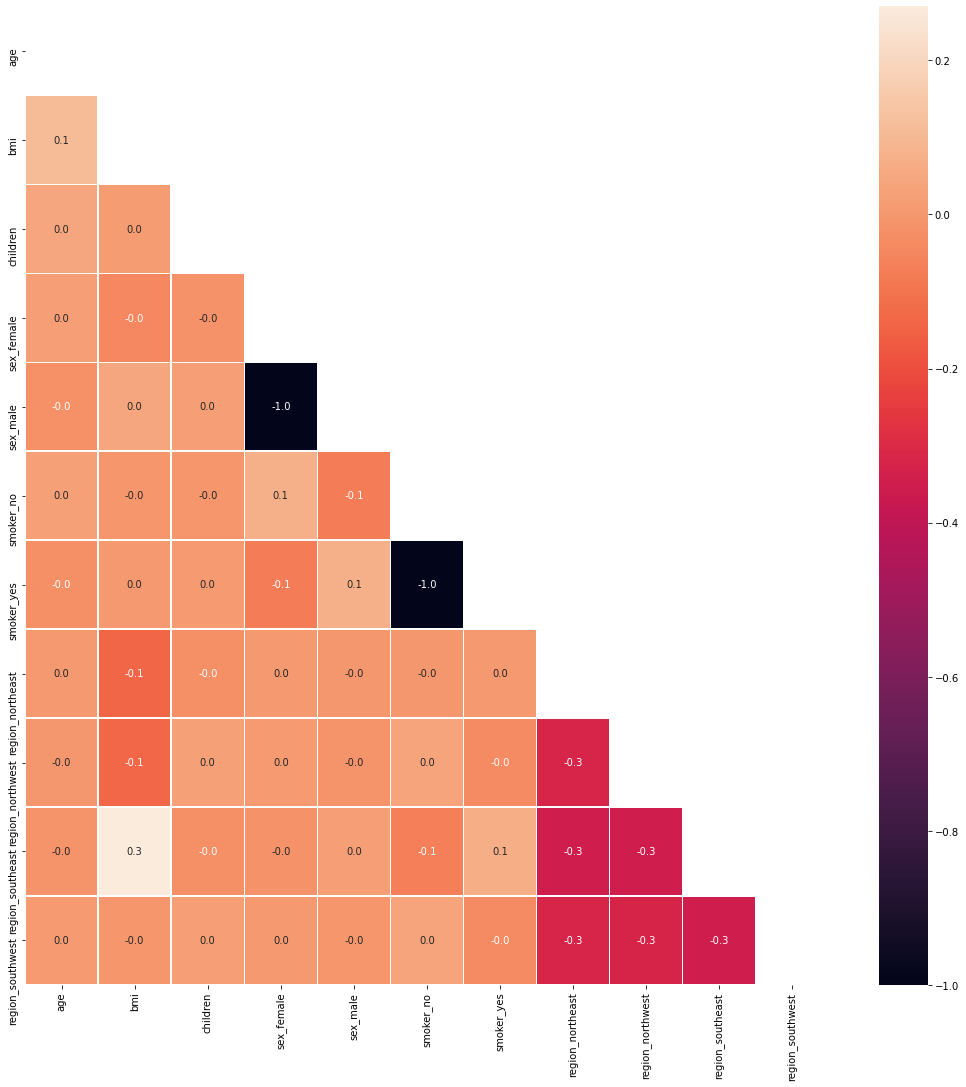

In [ ]:
f,ax = plt.subplots(figsize=(18, 18))
matrix = np.triu(X.corr())
se.heatmap(X.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, mask=matrix)
plt.show()

## **Data Splitting**
The train-test split is a procedure for evaluating the performance of an algorithm. The procedure involves taking a dataset and dividing it into two subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=123)

### **Model**
Least-angle regression (LARS) is a regression algorithm for high-dimensional data, developed by Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani. LARS is similar to forward stepwise regression. At each step, it finds the feature most correlated with the target. When there are multiple features having equal correlation, instead of continuing along the same feature, it proceeds in a direction equiangular between the features.

**Model Tuning Parameters**

    1. jitter 
> Upper bound on a uniform noise parameter to be added to the y values, to satisfy the model’s assumption of one-at-a-time computations. Might help with stability.

    2. eps 
> The machine-precision regularization in the computation of the Cholesky diagonal factors. Increase this for very ill-conditioned systems. Unlike the tol parameter in some iterative optimization-based algorithms, this parameter does not control the tolerance of the optimization.

    3. n_nonzero_coefs 
> Target number of non-zero coefficients. Use np.inf for no limit.

    4. precompute
> Whether to use a precomputed Gram matrix to speed up calculations.


**Data Rescaling**

Min Max Scaler 

Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

[Read more here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

<br>

**Data Transformation**

Quantile Transformer 

Transform features using quantiles information.

This method transforms the features to follow a uniform or a normal distribution. Therefore, for a given feature, this transformation tends to spread out the most frequent values. It also reduces the impact of (marginal) outliers: this is therefore a robust preprocessing scheme.

[Quantile Transformer API](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html)

In [ ]:
model = make_pipeline(MinMaxScaler(),QuantileTransformer(),Lars())
model.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('quantiletransformer',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=1000,
                                     output_distribution='uniform',
                                     random_state=None, subsample=100000)),
                ('lars',
                 Lars(copy_X=True, eps=2.220446049250313e-16,
                      fit_intercept=True, fit_path=True, n_nonzero_coefs=500,
                      normalize=True, precompute='auto', verbose=False))],
         verbose=False)

#### **Model Accuracy**
We will use the trained model to make a prediction on the test set.Then use the predicted value for measuring the accuracy of our model.

score: The score function returns the coefficient of determination R2 of the prediction.

In [ ]:
print("Accuracy score {:.2f} %\n".format(model.score(x_test,y_test)*100))

Accuracy score 79.94 %



> r2_score: The r2_score function computes the percentage variablility explained by our model, either the fraction or the count of correct predictions.

> mae: The mean abosolute error function calculates the amount of total error(absolute average distance between the real data and the predicted data) by our model.

> mse: The mean squared error function squares the error(penalizes the model for large errors) by our model.

In [ ]:
y_pred=model.predict(x_test)
print("R2 Score: {:.2f} %".format(r2_score(y_test,y_pred)*100))
print("Mean Absolute Error {:.2f}".format(mean_absolute_error(y_test,y_pred)))
print("Mean Squared Error {:.2f}".format(mean_squared_error(y_test,y_pred)))

R2 Score: 79.94 %
Mean Absolute Error 4108.64
Mean Squared Error 30666254.00


#### **Prediction Plot**
> First, we make use of a plot to plot the actual observations, with x_train on the x-axis and y_train on the y-axis. For the regression line, we will use x_train on the x-axis and then the predictions of the x_train observations on the y-axis.

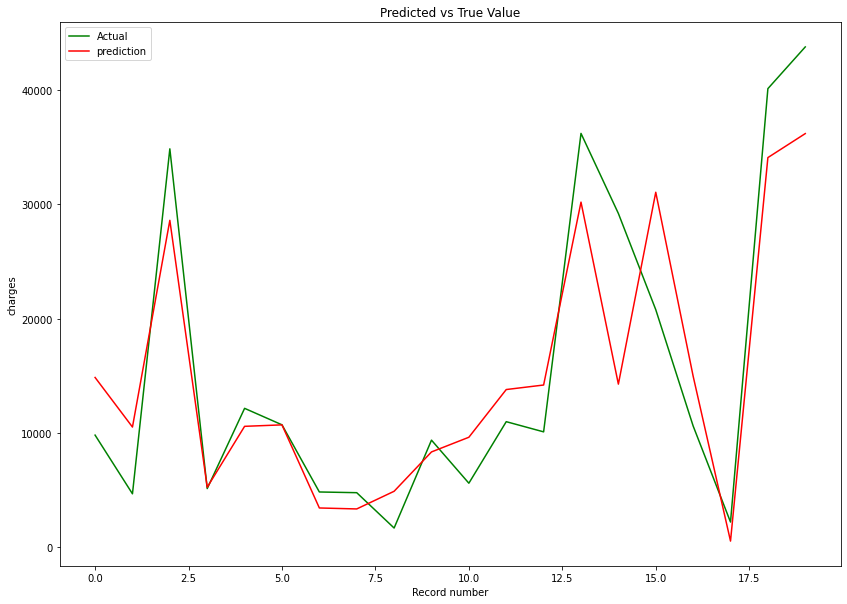

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(range(20),y_test[0:20], color = "green")
plt.plot(range(20),model.predict(x_test[0:20]), color = "red")
plt.legend(["Actual","prediction"]) 
plt.title("Predicted vs True Value")
plt.xlabel("Record number")
plt.ylabel(target)
plt.show()

#### Creator: Anu Rithiga B , Github: [Profile - Iamgrootsh7](https://github.com/iamgrootsh7)